Kütüphaneler

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import os
import pandas as pd
from torch.utils.data import (Dataset, DataLoader)
from skimage import io 
import time 
import warnings as w
w.filterwarnings("ignore")


Veri 

In [2]:
class veri(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return(image, y_label)


Veri Hazırlama

In [3]:

dataset = veri(csv_file=r"../../veriler/f1_classification/f111.csv", root_dir=r"../../veriler/f1_classification", transform=transforms.Compose([

    transforms.ToTensor(),
    transforms.Resize(size=(64, 64)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))


Veri Önişleme

In [4]:
train_set, test_set = torch.utils.data.random_split(dataset, [200, 79])
train_loader = DataLoader(dataset=train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset = test_set, batch_size=1, shuffle=True)

Veri Görselleştirme

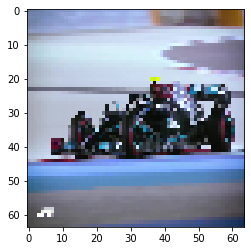

Mercedes
torch.Size([1, 3, 64, 64])


In [5]:
import matplotlib.pyplot as plt
import numpy as np

batch_size = 1
classes = ["Ferrari", "Mclaren", "Mercedes", "Redbull"]

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
print(images.size())

Model Eğitimi

In [14]:
import torchvision.models as models
model = models.googlenet(pretrained=False)

model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [16]:
model.fc = nn.Linear(in_features=1024, out_features=4, bias=True)
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
model.aux2.conv.bn=  nn.BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)

In [17]:
start = time.time()

error = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.01)

epoch=10
count = 0
iteration_list = []
loss_list = []


for i in range(epoch):
    for j, (images, label) in enumerate(train_loader):
        out = model(images)
        loss = error(out[1], label) 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        count += 1

        if count % 100 == 0:
            total = 0
            correct = 0
            correct_hata = 0
            for images, labels in test_loader:
                out=model(images.float())
                y_pred = torch.max(out[1].data,1)[1]
                total += len(labels)

                correct += (y_pred == labels).sum()
                correct_hata += (y_pred != labels).sum()

            accuracy = 100 * correct / float(total)
            hata = 100 * correct_hata / float(total)

            loss_list.append(loss.data)
            iteration_list.append(count)

        if count % 100 == 0:

            print("Iteration:{:4} Loss:{:4.4f} Accuracy:{:4.4f} Error:{:4.4f}".format(count, loss.data, accuracy, hata))


end = time.time()
print("Süre:", end-start)

Iteration: 100 Loss:0.0052 Accuracy:30.3797 Error:69.6203
Iteration: 200 Loss:0.9122 Accuracy:35.4430 Error:64.5570
Iteration: 300 Loss:2.4593 Accuracy:31.6456 Error:68.3544
Iteration: 400 Loss:1.9435 Accuracy:31.6456 Error:68.3544
Iteration: 500 Loss:2.0872 Accuracy:31.6456 Error:68.3544
Iteration: 600 Loss:0.4018 Accuracy:37.9747 Error:62.0253
Iteration: 700 Loss:0.3681 Accuracy:27.8481 Error:72.1519
Iteration: 800 Loss:1.6515 Accuracy:37.9747 Error:62.0253
Iteration: 900 Loss:2.5721 Accuracy:36.7089 Error:63.2911
Iteration:1000 Loss:0.8527 Accuracy:35.4430 Error:64.5570
Iteration:1100 Loss:1.6476 Accuracy:35.4430 Error:64.5570
Iteration:1200 Loss:0.5508 Accuracy:44.3038 Error:55.6962
Iteration:1300 Loss:0.8756 Accuracy:32.9114 Error:67.0886
Iteration:1400 Loss:0.3311 Accuracy:30.3797 Error:69.6203
Iteration:1500 Loss:0.3518 Accuracy:43.0380 Error:56.9620
Iteration:1600 Loss:0.8151 Accuracy:39.2405 Error:60.7595
Iteration:1700 Loss:0.8955 Accuracy:43.0380 Error:56.9620
Iteration:1800

Model Testi

In [8]:
def dogruluk(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    device=torch.device("cuda")
    model = model.to(device)

    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)

            out = model(x.float())
            _, pred = out.max(1)
            num_correct += (pred == y).sum()
            num_samples += pred.size(0)

        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}")
        model.train()


In [9]:
print("train doğruluk:")
dogruluk(train_loader, model)

print("test doğruluk:")
dogruluk(test_loader, model)

train doğruluk:
Got 52 / 200 with accuracy 26.00
test doğruluk:
Got 18 / 79 with accuracy 22.78
